### Optimal control of phenomenological models, e.g. the model model
This notebook shows how to compute the optimal control (OC) signal for the model model for a simple example task. For the Hopf-model the OC can be computed completely analogously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [2]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.011225367461896877
y_init = 0.013126741089502588
model.params["exc_init"] = np.array([[x_init]])
model.params["inh_init"] = np.array([[y_init]])

0.011225367461896877
0.013126741089502588


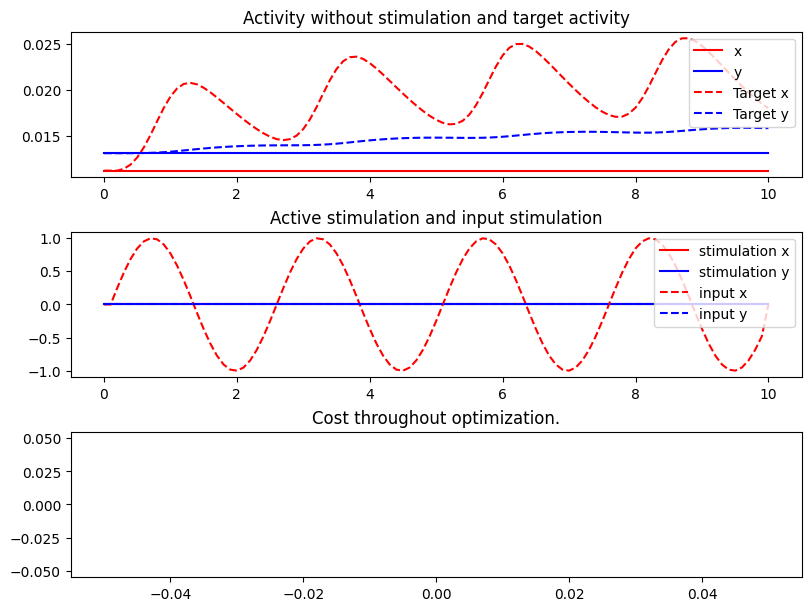

In [3]:
# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

print(state[0,0,-1])
print(state[0,1,-1])

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 0.0004181055419829032
Cost in iteration 25: 1.0534061674558321e-05
Cost in iteration 50: 3.926634822217583e-06
Cost in iteration 75: 2.1057234366322948e-06
Cost in iteration 100: 1.399067240843738e-06
Cost in iteration 125: 1.0225499625879488e-06
Cost in iteration 150: 7.973393565056235e-07
Cost in iteration 175: 6.520407545689918e-07
Cost in iteration 200: 5.444755723773666e-07
Cost in iteration 225: 4.6453384478788947e-07
Cost in iteration 250: 4.017335905650733e-07
Cost in iteration 275: 3.511108806485453e-07
Cost in iteration 300: 3.096217181113268e-07
Cost in iteration 325: 2.7525697267739466e-07
Cost in iteration 350: 2.4668010370236156e-07
Cost in iteration 375: 2.2172345028519215e-07
Cost in iteration 400: 2.0074681504172223e-07
Cost in iteration 425: 1.8311904513265896e-07
Cost in iteration 450: 1.6683364203591327e-07
Cost in iteration 475: 1.5342008355908467e-07
Cost in iteration 500: 1.409513420636086e-07
Final 

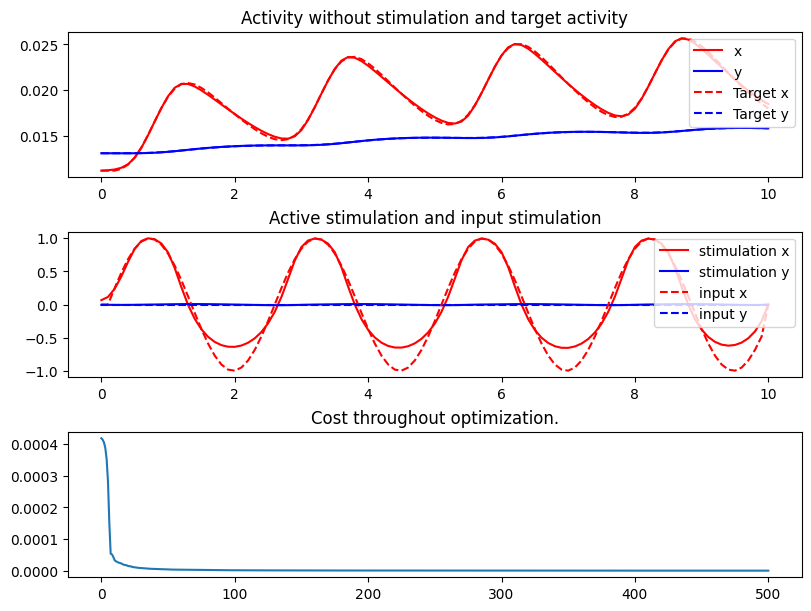

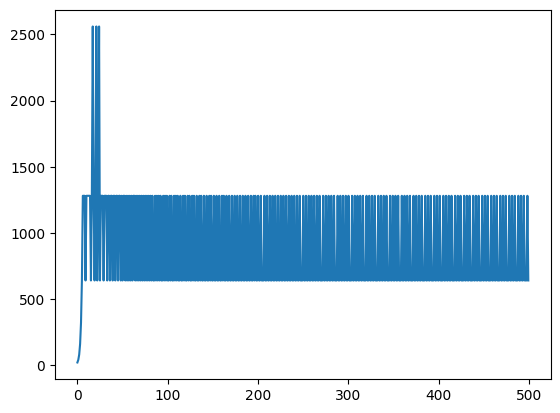

In [4]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=np.arange(0,501,25))

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()


Compute control for a deterministic system
Cost in iteration 0: 1.409513420636086e-07
Cost in iteration 25: 1.3060181047282059e-07
Cost in iteration 50: 1.2071708613893395e-07
Cost in iteration 75: 1.1216842082684616e-07
Cost in iteration 100: 1.0460006015003307e-07
Final cost : 1.0460006015003307e-07


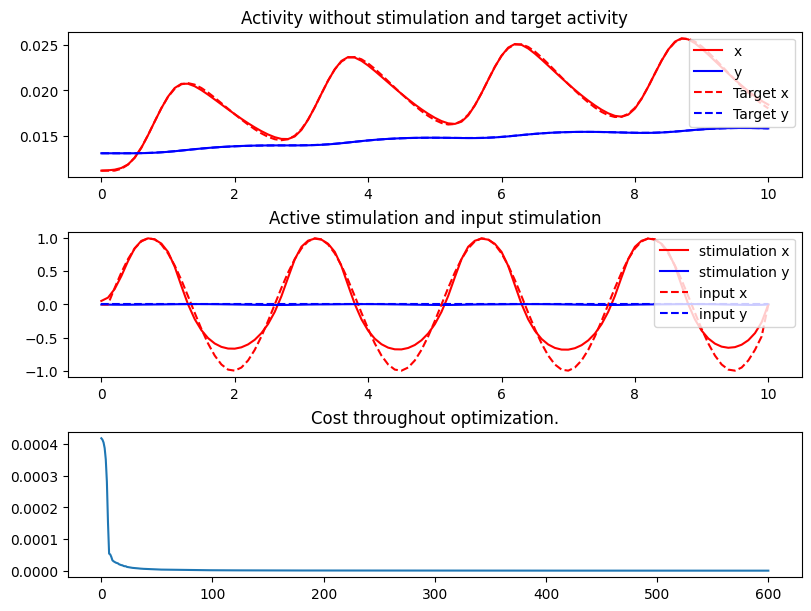

In [5]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

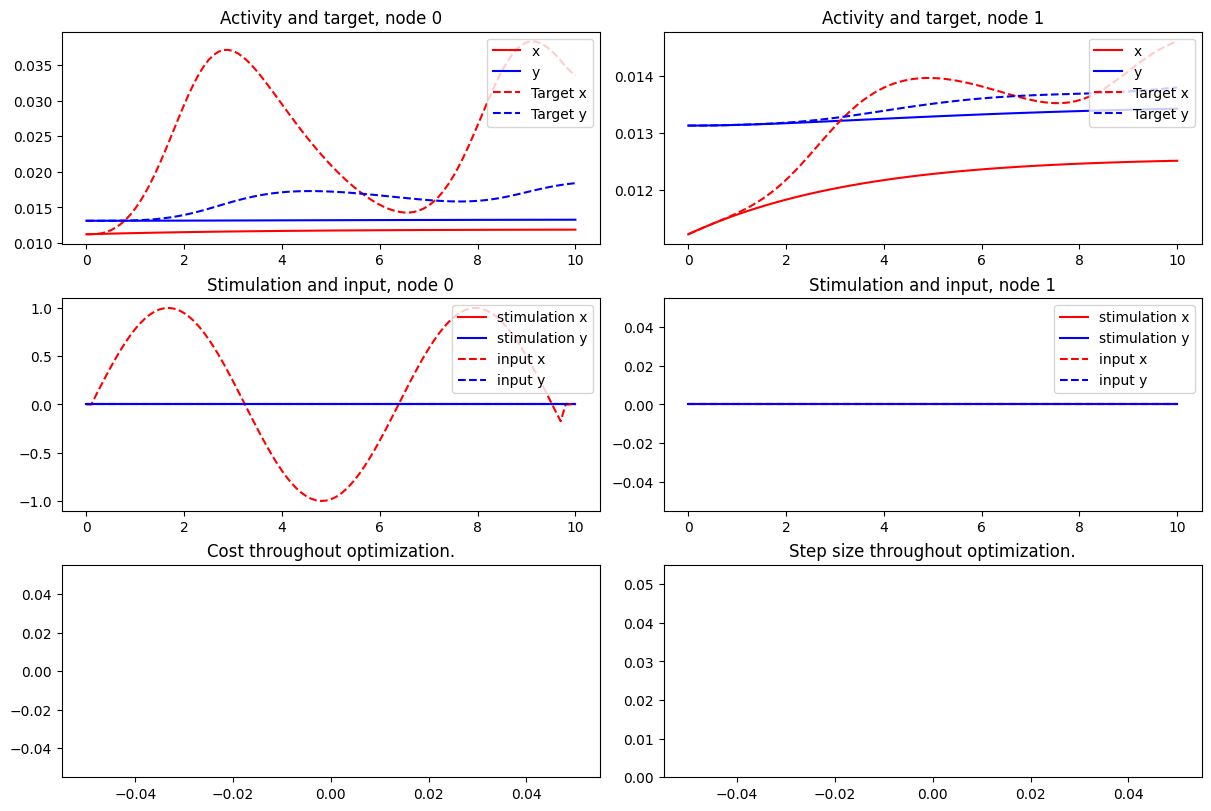

In [6]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = WCModel(Cmat=cmat, Dmat=dmat)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

model.params.K_gl = 5.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["exc_init"] = np.vstack( [x_init, x_init] )
model.params["inh_init"] = np.vstack( [y_init, y_init] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 8.117061134315108e-06
Cost in iteration 25: 4.038414882243976e-07
Cost in iteration 50: 2.1412677497671776e-07
Cost in iteration 75: 1.0691514730810668e-07
Cost in iteration 100: 6.282735078991827e-08
Cost in iteration 125: 3.526636166231236e-08
Cost in iteration 150: 2.2436056921896874e-08
Cost in iteration 175: 1.578279847952951e-08
Cost in iteration 200: 1.1425183662715832e-08
Cost in iteration 225: 8.832812904703324e-09
Cost in iteration 250: 6.984827828589208e-09
Cost in iteration 275: 5.727800724994055e-09
Cost in iteration 300: 4.821811876270457e-09
Cost in iteration 325: 4.1678777126601e-09
Cost in iteration 350: 3.6580169981382154e-09
Cost in iteration 375: 3.2723309341123373e-09
Cost in iteration 400: 2.9591769931415473e-09
Cost in iteration 425: 2.7144053826161382e-09
Cost in iteration 450: 2.5092034971287625e-09
Cost in iteration 475: 2.339165451489362e-09
Cost in iteration 500: 2.1947200858861965e-09
Final cos

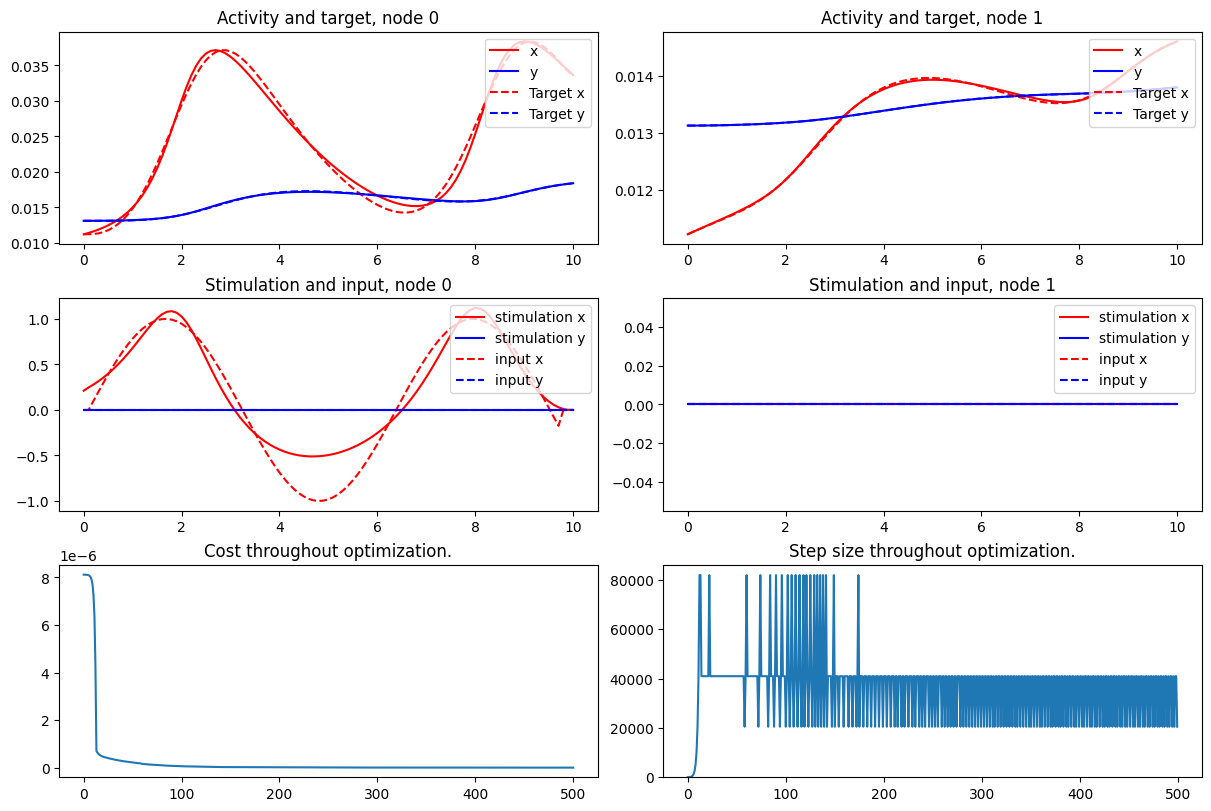

In [7]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=np.arange(0,501,25), control_matrix=control_mat, precision_matrix=prec_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 2.1947200858861965e-09
Cost in iteration 25: 2.0700526811368516e-09
Cost in iteration 50: 1.9613650574728087e-09
Cost in iteration 75: 1.8661181051371725e-09
Cost in iteration 100: 1.7793702903907821e-09
Final cost : 1.7793702903907821e-09


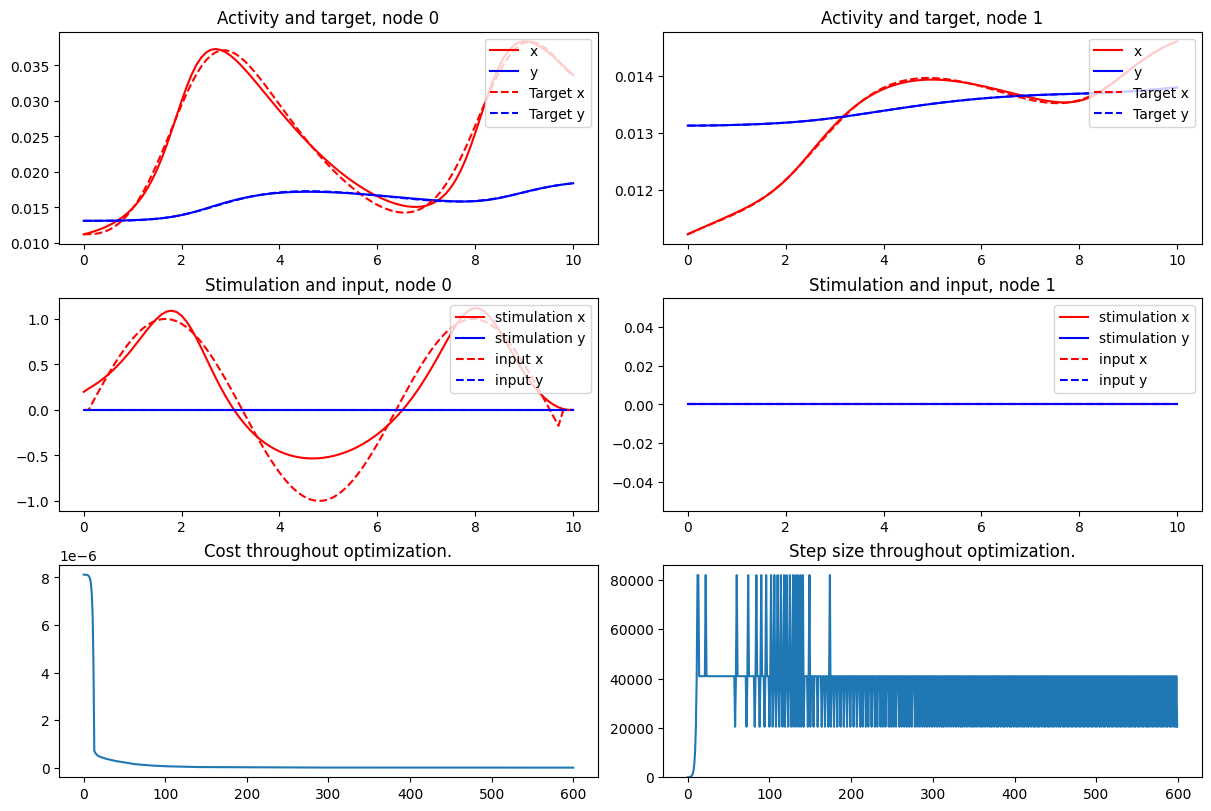

In [8]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

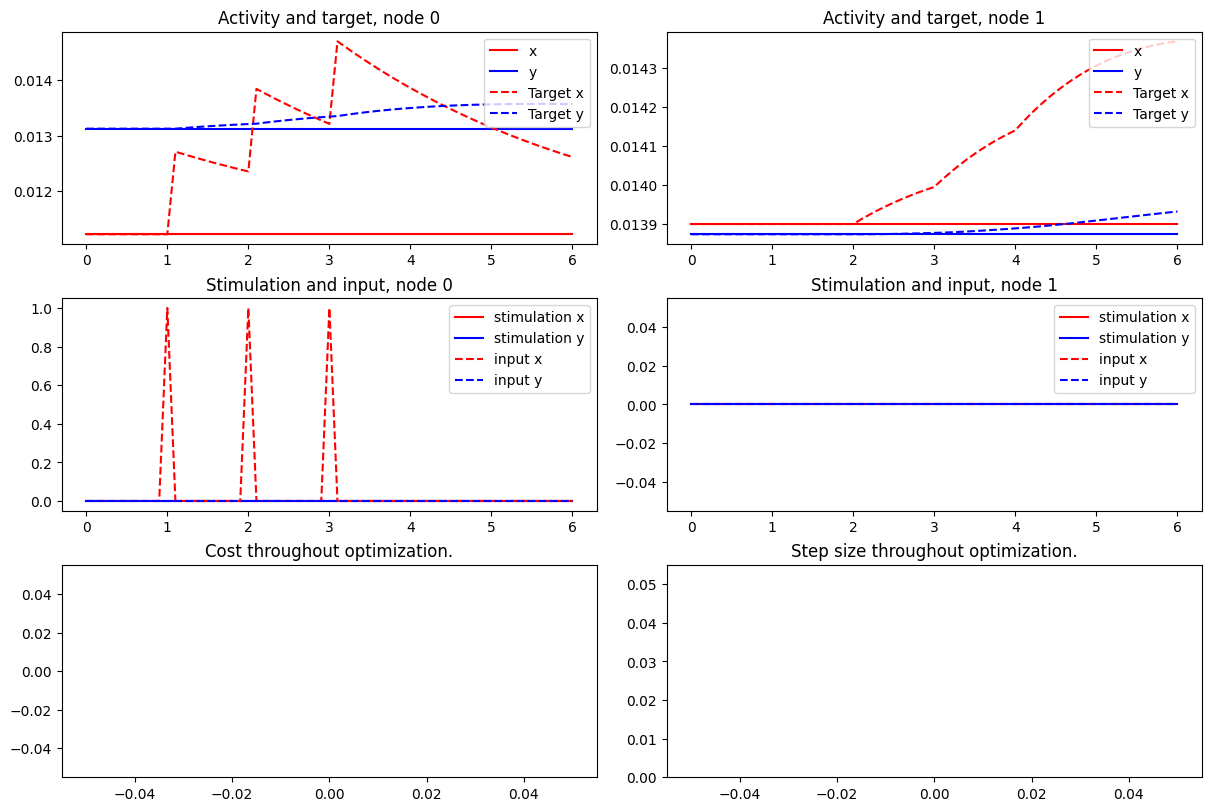

In [9]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

model = WCModel(Cmat=cmat, Dmat=dmat)

duration, dt = 2000., 0.1
model.params.duration = duration
model.params.dt = dt
model.params.K_gl = 10.

model.run()

e0 = model.exc[0,-1]
e1 = model.exc[1,-1]
i0 = model.inh[0,-1]
i1 = model.inh[1,-1]

maxdelay = model.getMaxDelay()

model.params["exc_init"] = np.array([[e0] * (maxdelay + 1), [e1] * (maxdelay + 1) ])
model.params["inh_init"] = np.array([[i0] * (maxdelay + 1), [i1] * (maxdelay + 1) ])

duration = 6.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,10] = 1. 
input[0,20] = 1.
input[0,30] = 1. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["exc_init"][:,-1], model.params["inh_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate( (np.stack( (model.params["exc_init"][:,-1], model.params["inh_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 1.79283505339136e-07
Cost in iteration 25: 3.2247859692740393e-10
Cost in iteration 50: 1.0235645125832315e-10
Cost in iteration 75: 8.627118082750973e-11
Cost in iteration 100: 8.0959155796619e-11
Cost in iteration 125: 6.901386106042257e-11
Cost in iteration 150: 6.56353013001263e-11
Cost in iteration 175: 6.357435989747784e-11
Cost in iteration 200: 5.819409921457177e-11
Cost in iteration 225: 5.599071625993011e-11
Cost in iteration 250: 5.459949923554019e-11
Cost in iteration 275: 5.102051796559545e-11
Cost in iteration 300: 4.953180878534184e-11
Cost in iteration 325: 4.873701053744886e-11
Cost in iteration 350: 4.599566625881343e-11
Cost in iteration 375: 4.505545916877666e-11
Cost in iteration 400: 4.328740550207489e-11
Cost in iteration 425: 4.241861957144191e-11
Cost in iteration 450: 4.1218981557194096e-11
Cost in iteration 475: 4.0367113079919566e-11
Cost in iteration 500: 3.991327147870625e-11
Final cost : 3.99

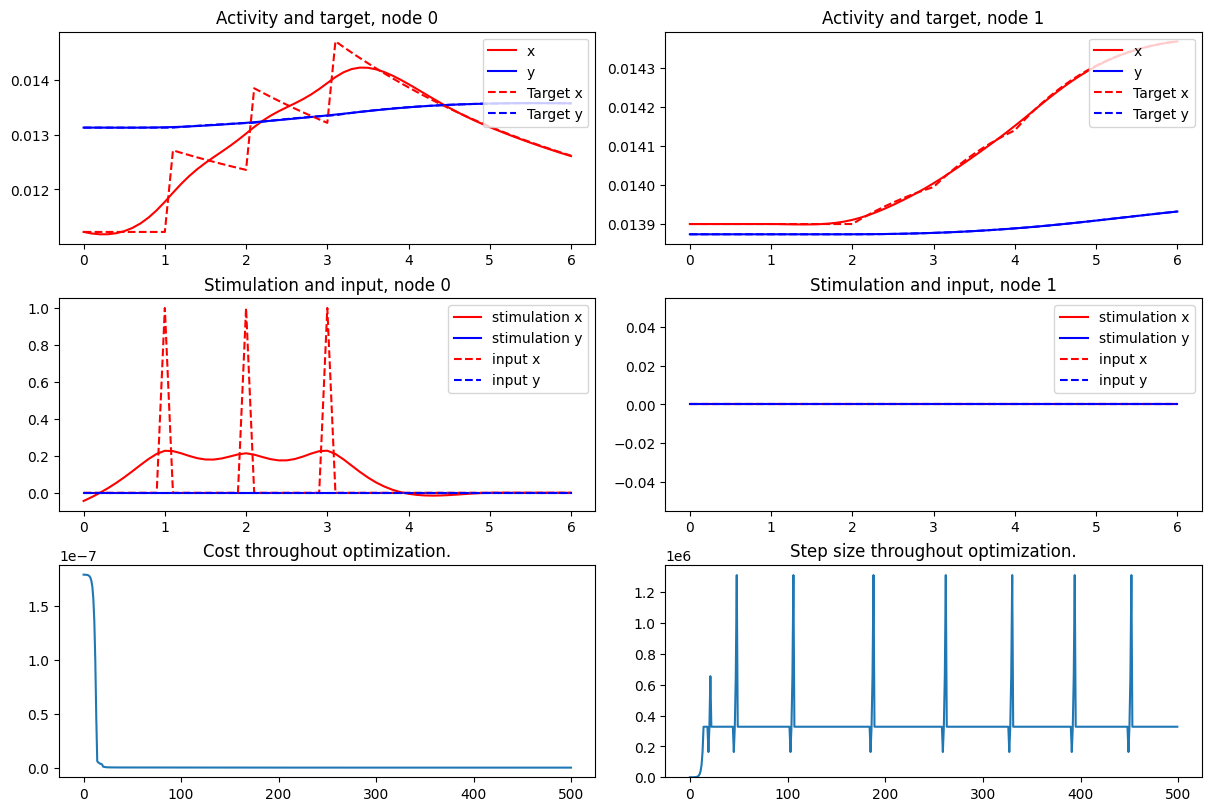

In [10]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=np.arange(0,501,25), control_matrix=control_mat, precision_matrix=prec_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 3.991327147870625e-11
Cost in iteration 25: 3.8702776550654146e-11
Cost in iteration 50: 3.8279334916348465e-11
Cost in iteration 75: 3.731446493226131e-11
Cost in iteration 100: 3.694451933458019e-11
Final cost : 3.694451933458019e-11


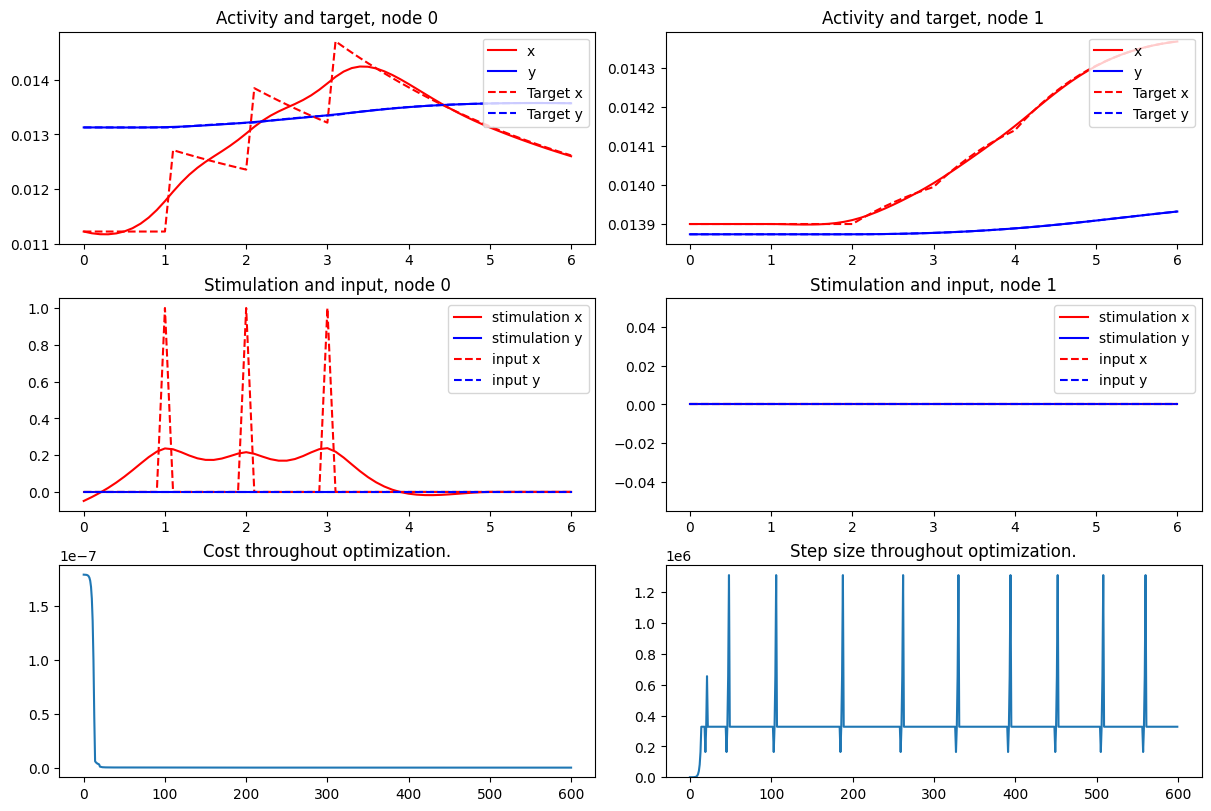

In [11]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 500 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)